# load task behavioural scores

In [1]:
import pandas as pd
import seaborn

In [2]:
dfb = pd.read_csv('/Users/qasem/PycharmProjects/grad_ecc_RL_data/RL_behavior.csv')  # df behaviour

In [3]:
dfb.head()

,Subject,Block,Trial,Score,ReactionTime,MovementTime,Valid
0,AB1,1,1,53.0,0.365009,0.182444,True
1,AB1,1,2,51.0,0.548555,0.402011,True
2,AB1,1,3,7.0,0.472627,0.269147,True
3,AB1,1,4,0.0,0.557651,0.289636,True
4,AB1,1,5,34.0,0.588884,0.211777,True


## calculate t-test as metric

In [4]:
import pingouin as pg

In [5]:
def ttest_init_final(df_subj):
    df_subj = df_subj[df_subj.Trial.notna()]
    # iloc[:n] takes first n rows, not till index n
    x, y = df_subj.iloc[:20]['Score'], df_subj.iloc[-20:]['Score']
    return pg.ttest(x, y, paired=True, alternative='less').iloc[0,0]

In [6]:
fpca_scores = pd.read_csv('data/RLfpcaScores.csv').set_index('Subject')
metrics = dfb[dfb.Block==2].groupby('Subject').apply(ttest_init_final)
metrics = metrics.rename('tscore').to_frame().join(fpca_scores, how='inner')

In [39]:
metrics

,tscore,RLScore
Subject,,
AB1,-7.195868,-1.179789
AG1,-5.822339,1.104018
AH1,-2.248812,-0.302101
AM1,-6.593196,-1.400917
AP1,-15.539946,0.868475
AV1,-4.009663,0.859943
BN1,-6.426085,1.433999
CD1,-11.893333,-0.661215
CG1,-3.318209,-0.337563


In [51]:
from mlxtend.evaluate import permutation_test

a = [1, 2, 3, 4, 5, 6]
b = [1, 2, 9, 4, 4]

permutation_test(a, b, method='approximate',
                 num_rounds=10_000,seed=0)

0.8282171782821718

In [8]:
import seaborn as sns

<AxesSubplot:xlabel='tscore', ylabel='RLScore'>

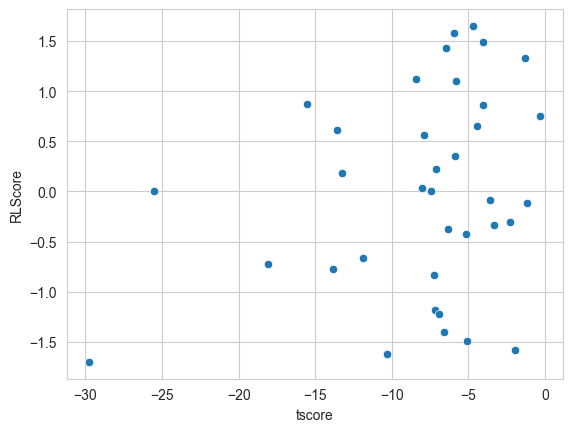

In [9]:
sns.scatterplot(data=metrics, x='tscore', y='RLScore')

# load gradients

In [10]:
dfg = pd.read_csv('data/gradients.csv')  # df gradient values
dfg

,subject,epoch,region,7net,17net,g1,g2,g3,g4,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,-0.668984,1.732833
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,-0.758676,1.978984
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,0.007569,1.954366
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,-0.858037,3.257601
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,0.278002,1.298746
...,...,...,...,...,...,...,...,...,...,...
109291,46,late,Right Putamen,Striatum,StriatumRight,-0.861413,-0.664291,-0.450307,-1.694324,2.063208
109292,46,late,Right Pallidum,Striatum,StriatumRight,-0.530126,-0.774942,-0.468807,-1.149747,1.556685
109293,46,late,Right Hippocampus,Striatum,StriatumRight,-0.938860,-0.247830,-1.223909,-1.464685,2.141526
109294,46,late,Right Amygdala,Striatum,StriatumRight,-1.114832,-0.355354,-1.374354,-1.242685,2.191402


In [11]:
match = pd.read_csv('/Users/qasem/PycharmProjects/gradients-rl-task/data/participants.tsv', delimiter='\t')
dff = pd.merge(dfg, match[match.exclude==0], left_on='subject', right_on='participant_id', how='inner') # df features
dff = dff.rename(columns={'dicom_dir': 'Subject'})
dff = dff.set_index(['subject', 'Subject', 'epoch', 'region', '7net', '17net'])[['ecc']].unstack('epoch')   # make epochs differentiable
dff = dff.droplevel(level=0, axis=1)

In [12]:
dff['b2e'] = dff['early'] - dff['baseline']
dff['e2l'] = dff['late'] - dff['early']
dff = dff.reorder_levels([2, 3, 4, 0, 1])
dff.head()

,,,,epoch,baseline,early,late,b2e,e2l
region,7net,17net,subject,Subject,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716


In [13]:
df = dff.reset_index(level=[0,1,2,3]).join(metrics)  # metrics and features merged
df = df.set_index(['region', '7net', '17net', 'subject', df.index])

In [14]:
df.head()

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-7.195868,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-7.195868,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-7.195868,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-7.195868,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-7.195868,-1.179789


# cross correlation

In [15]:
from scipy.stats import pearsonr

In [16]:
def r_value(data, x, y):   return pearsonr(data[x], data[y])[0]
def p_value(data, x, y):   return pearsonr(data[x], data[y])[1]

<AxesSubplot:xlabel='b2e', ylabel='tscore'>

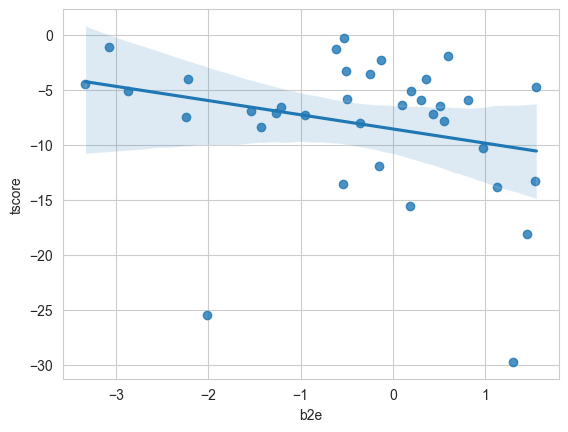

In [17]:
sns.regplot(data=df.loc['7Networks_LH_Default_PFC_9'], x='b2e', y='tscore')

## average features within networks

In [18]:
df.head()

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-7.195868,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-7.195868,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-7.195868,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-7.195868,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-7.195868,-1.179789


In [19]:
##################################
dfn = df.groupby(level=[1,2,3,4]).mean()  # df networks mean

In [20]:
# dfn.xs('JS1', level=2)
dfn.dropna(inplace=True)

In [21]:
dfn.head()

baseline     early      late       b2e       e2l  \
7net 17net subject Subject                                                     
Cont ContA 1       AB1      2.291505  2.423845  2.964161  0.132340  0.540316   
           2       AG1      2.614807  2.769666  2.831087  0.154859  0.061421   
           3       AH1      2.992396  2.648465  2.454868 -0.343931 -0.193597   
           4       AM1      2.427199  2.624691  2.918770  0.197492  0.294079   
           6       AP1      2.649026  2.992993  2.724508  0.343967 -0.268485   

                               tscore   RLScore  
7net 17net subject Subject                       
Cont ContA 1       AB1      -7.195868 -1.179789  
           2       AG1      -5.822339  1.104018  
           3       AH1      -2.248812 -0.302101  
           4       AM1      -6.593196 -1.400917  
           6       AP1     -15.539946  0.868475

In [22]:
# dfn.reset_index()['17net'].unique()

In [23]:
dfn.reorder_levels([1,0,2,3]).loc['DorsAttnA']

baseline     early      late       b2e       e2l  \
7net    subject Subject                                                     
Default 1       AB1      2.562454  2.363510  1.454643 -0.198944 -0.908866   
        2       AG1      4.012320  2.466140  1.979594 -1.546180 -0.486546   
        3       AH1      2.042421  2.813075  2.134133  0.770654 -0.678942   
        4       AM1      2.511907  3.279340  1.723101  0.767433 -1.556239   
        6       AP1      1.395903  1.039219  1.858299 -0.356684  0.819079   
...                           ...       ...       ...       ...       ...   
Vis     40      SM2      2.784789  3.065027  3.230875  0.280238  0.165848   
        41      SR1      3.051244  3.038436  3.784219 -0.012808  0.745783   
        44      UP1      3.672952  3.997868  3.383750  0.324916 -0.614118   
        45      WK1      3.762854  2.487076  3.573099 -1.275778  1.086023   
        46      ZN1      4.904333  3.103685  3.153452 -1.800647  0.049766   

                            tscore   RLScore  
7net    subject Subject                       
Default 1       AB1      -7.195868 -1.179789  
        2       AG1      -5.822339  1.104018  
        3       AH1      -2.248812 -0.302101  
        4       AM1      -6.593196 -1.400917  
        6       AP1     -15.539946  0.868475  
...                            ...       ...  
Vis     40      SM2      -8.408968  1.119882  
        41      SR1      -7.447315  0.007867  
        44      UP1      -5.891292  0.350276  
        45      WK1      -4.692163  1.649951  
        46      ZN1      -1.138829 -0.116459  

[108 rows x 7 columns]

In [24]:
dfn.loc['Limbic']

baseline     early      late       b2e       e2l  \
17net    subject Subject                                                     
DefaultC 1       AB1      1.409654  1.536180  1.884608  0.126526  0.348428   
         2       AG1      1.688477  1.476811  1.839387 -0.211666  0.362576   
         3       AH1      1.736916  1.888232  1.368670  0.151317 -0.519562   
         4       AM1      1.363531  1.537207  1.652460  0.173676  0.115253   
         6       AP1      2.432180  1.868254  1.763137 -0.563926 -0.105117   
...                            ...       ...       ...       ...       ...   
LimbicB  40      SM2      2.319706  2.239065  1.908199 -0.080641 -0.330866   
         41      SR1      2.496397  2.187659  2.172545 -0.308738 -0.015115   
         44      UP1      2.170361  2.469317  1.896353  0.298956 -0.572963   
         45      WK1      2.346741  2.114401  2.452813 -0.232340  0.338412   
         46      ZN1      3.266769  2.334368  2.421351 -0.932401  0.086983   

                             tscore   RLScore  
17net    subject Subject                       
DefaultC 1       AB1      -7.195868 -1.179789  
         2       AG1      -5.822339  1.104018  
         3       AH1      -2.248812 -0.302101  
         4       AM1      -6.593196 -1.400917  
         6       AP1     -15.539946  0.868475  
...                             ...       ...  
LimbicB  40      SM2      -8.408968  1.119882  
         41      SR1      -7.447315  0.007867  
         44      UP1      -5.891292  0.350276  
         45      WK1      -4.692163  1.649951  
         46      ZN1      -1.138829 -0.116459  

[108 rows x 7 columns]

<AxesSubplot:xlabel='b2e', ylabel='RLScore'>

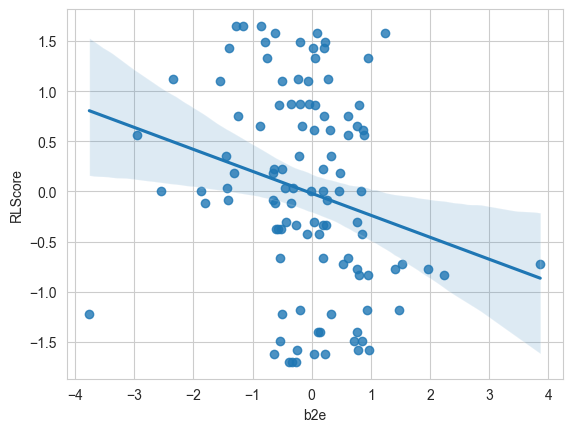

In [25]:
sns.regplot(data=dfn.reorder_levels([1,0,2,3]).loc['DorsAttnA'], x='b2e', y='RLScore')

<AxesSubplot:xlabel='b2e', ylabel='RLScore'>

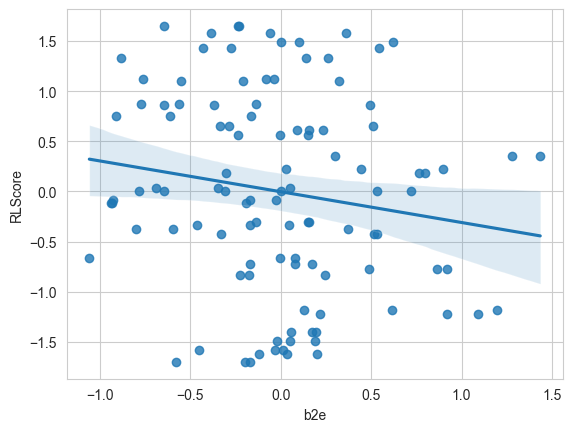

In [26]:
sns.regplot(data=dfn.loc['Limbic'], x='b2e', y='RLScore')

In [27]:
dfc = []    # cross correlation
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore']
for y in Y:
    for x in X:
        r = dfn.groupby(level=1).apply(r_value, x=x, y=y)    # grouped by network
        p = dfn.groupby(level=1).apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        dfc.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
dfc = pd.concat(dfc, axis=1, keys=[x+'__'+y for x in X for y in Y])

In [28]:
dfc

baseline__RLScore                     early__RLScore            \
                              r         p      pcor              r         p   
17net                                                                          
ContA                  0.135943  0.160665  0.839115       0.163762  0.090358   
ContB                 -0.110344  0.356147  0.850944       0.009216  0.938757   
ContC                 -0.203541  0.006134  0.116555      -0.142177  0.056924   
DefaultA              -0.071501  0.678584  0.974193      -0.161892  0.345519   
DefaultB               0.059165  0.731777  0.974193      -0.080667  0.640011   
DefaultC               0.032904  0.695420  0.974193      -0.098816  0.238660   
DorsAttnA              0.013979  0.885825  0.974193      -0.266449  0.005314   
DorsAttnB             -0.009420  0.922919  0.974193      -0.047144  0.628026   
LimbicA                0.032224  0.851999  0.974193      -0.193746  0.257542   
LimbicB                0.072218  0.457637  0.962419       0.001650  0.986475   
SalVentAttnA           0.146072  0.220820  0.839115      -0.009004  0.940165   
SalVentAttnB           0.184447  0.056010  0.532095      -0.002493  0.979574   
SomMotA                0.109855  0.358292  0.850944       0.075617  0.527839   
SomMotB                0.150560  0.206806  0.839115      -0.139859  0.241302   
StriatumLeft          -0.002895  0.986628  0.986628      -0.148715  0.386694   
StriatumRight         -0.025482  0.882721  0.974193      -0.115169  0.503587   
TempPar               -0.033501  0.690177  0.974193      -0.097203  0.246449   
VisCent                0.161951  0.345341  0.850944      -0.300751  0.074693   
VisPeri                0.114379  0.506536  0.962419      -0.168158  0.326915   

                        late__RLScore                     b2e__RLScore  \
                   pcor             r         p      pcor            r   
17net                                                                    
ContA          0.429198     -0.018285  0.851015  0.966155     0.024083   
ContB          0.986475      0.026450  0.825444  0.966155     0.077933   
ContC          0.429198      0.129240  0.083788  0.597879     0.090199   
DefaultA       0.656487      0.013985  0.935482  0.966155    -0.063962   
DefaultB       0.810681     -0.007330  0.966155  0.966155    -0.091162   
DefaultC       0.611662      0.037503  0.655401  0.966155    -0.118858   
DorsAttnA      0.100959      0.151549  0.117424  0.597879    -0.227572   
DorsAttnB      0.810681      0.014807  0.879114  0.966155    -0.028906   
LimbicA        0.611662      0.198323  0.246250  0.597879    -0.167592   
LimbicB        0.986475     -0.033679  0.729318  0.966155    -0.060302   
SalVentAttnA   0.986475     -0.153713  0.197346  0.597879    -0.135335   
SalVentAttnB   0.986475     -0.123040  0.204577  0.597879    -0.135208   
SomMotA        0.771458     -0.103845  0.385349  0.732163    -0.017998   
SomMotB        0.611662     -0.019594  0.870229  0.966155    -0.277448   
StriatumLeft   0.667926     -0.183815  0.283206  0.597879    -0.093722   
StriatumRight  0.771458     -0.306276  0.069257  0.597879    -0.054654   
TempPar        0.611662      0.037214  0.657885  0.966155    -0.048275   
VisCent        0.429198      0.186025  0.277358  0.597879    -0.263635   
VisPeri        0.656487      0.206005  0.228054  0.597879    -0.178135   

                                  e2l__RLScore                      
                      p      pcor            r         p      pcor  
17net                                                               
ContA          0.804597  0.849297    -0.115930  0.232169  0.605225  
ContB          0.515238  0.810163     0.008436  0.943933  0.943933  
ContC          0.228524  0.693651     0.187580  0.011684  0.111000  
DefaultA       0.710928  0.849297     0.111524  0.517274  0.702014  
DefaultB       0.596962  0.810163     0.055603  0.747383  0.866260  
DefaultC       0.155929  0.619240     0.133974  0.109398  0.514084  
Dor

In [29]:
p = dfc.xs('p', axis=1, level=1)
(p<.05).sum()

baseline__RLScore    1
early__RLScore       1
late__RLScore        0
b2e__RLScore         2
e2l__RLScore         2
dtype: int64

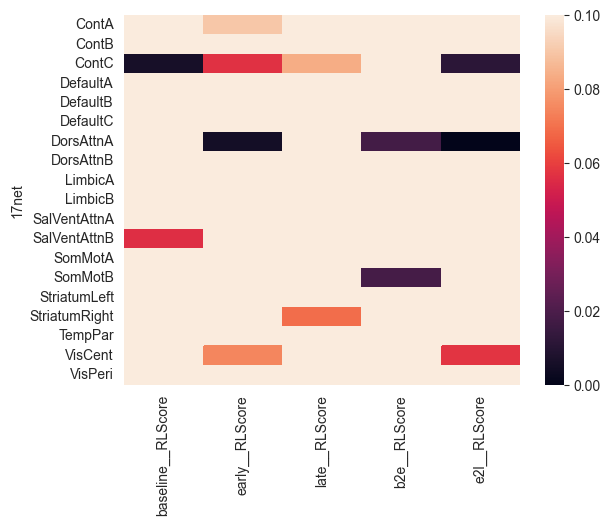

In [30]:
ax = sns.heatmap(dfc.xs('p', axis=1, level=1), vmin=0, vmax=.1)
# ax.vlines(5, *ax.get_ylim())

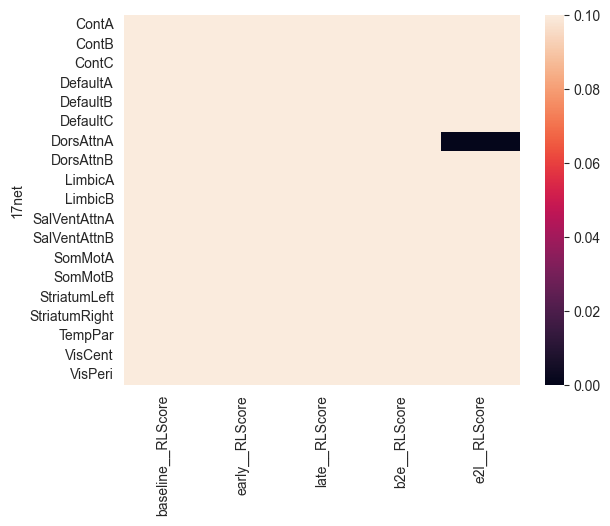

In [31]:
ax = sns.heatmap(dfc.xs('pcor', axis=1, level=1), vmin=0, vmax=.1)
# ax.vlines(5, *ax.get_ylim())

# group by region

In [32]:
df

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-7.195868,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-7.195868,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-7.195868,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-7.195868,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-7.195868,-1.179789
...,...,...,...,...,...,...,...,...,...,...,...
Right Caudate,Striatum,StriatumRight,46,ZN1,1.205411,1.602331,2.248230,0.396920,0.645899,-1.138829,-0.116459
Right Hippocampus,Striatum,StriatumRight,46,ZN1,2.247534,2.148846,2.141526,-0.098688,-0.007320,-1.138829,-0.116459
Right Pallidum,Striatum,StriatumRight,46,ZN1,1.111373,1.411745,1.556685,0.300372,0.144939,-1.138829,-0.116459


In [33]:
dfcr = []    # cross correlation
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore']
for y in Y:
    for x in X:
        r = df.groupby(level=0).apply(r_value, x=x, y=y)    # grouped by network
        p = df.groupby(level=0).apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        dfcr.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
dfcr = pd.concat(dfcr, axis=1, keys=[x+'__'+y for x in X for y in Y])

In [34]:
dfcr

baseline__RLScore                     early__RLScore  \
                                         r         p      pcor              r   
region                                                                          
7Networks_LH_Cont_Cing_1          0.166323  0.332298  0.989760       0.122089   
7Networks_LH_Cont_Cing_2         -0.094146  0.584959  0.989760      -0.355747   
7Networks_LH_Cont_Cing_3          0.030368  0.860437  0.991502      -0.251122   
7Networks_LH_Cont_Cing_4          0.169644  0.322596  0.989760       0.144244   
7Networks_LH_Cont_Cing_5          0.422829  0.010193  0.989760      -0.307655   
...                                    ...       ...       ...            ...   
Right Caudate                     0.202017  0.237382  0.989760      -0.106495   
Right Hippocampus                -0.068674  0.690649  0.989760      -0.171121   
Right Pallidum                    0.061660  0.720908  0.989760       0.057587   
Right Putamen                    -0.066944  0.698071  0.989760      -0.003174   
Right Thalamus                   -0.250019  0.141388  0.989760       0.061610   

                                             late__RLScore            \
                                 p      pcor             r         p   
region                                                                 
7Networks_LH_Cont_Cing_1  0.478111  0.949064     -0.156780  0.361165   
7Networks_LH_Cont_Cing_2  0.033224  0.764154      0.311559  0.064353   
7Networks_LH_Cont_Cing_3  0.139583  0.888416      0.275570  0.103793   
7Networks_LH_Cont_Cing_4  0.401287  0.949064      0.030282  0.860827   
7Networks_LH_Cont_Cing_5  0.067949  0.845800      0.163002  0.342180   
...                            ...       ...           ...       ...   
Right Caudate             0.536457  0.949064     -0.386615  0.019848   
Right Hippocampus         0.318340  0.949064     -0.266703  0.115863   
Right Pallidum            0.738679  0.965818     -0.265629  0.117394   
Right Putamen             0.985342  0.999529      0.038850  0.822010   
Right Thalamus            0.721128  0.964150     -0.159831  0.351777   

                                   b2e__RLScore                      \
                              pcor            r         p      pcor   
region                                                                
7Networks_LH_Cont_Cing_1  0.996365    -0.004711  0.978244  0.988007   
7Networks_LH_Cont_Cing_2  0.996365    -0.169190  0.323912  0.934343   
7Networks_LH_Cont_Cing_3  0.996365    -0.188462  0.270999  0.934343   
7Networks_LH_Cont_Cing_4  0.996365    -0.028071  0.870900  0.985405   
7Networks_LH_Cont_Cing_5  0.996365    -0.446280  0.006367  0.916937   
...                            ...          ...       ...       ...   
Right Caudate             0.996365    -0.211998  0.214507  0.934343   
Right Hippocampus         0.996365    -0.079027  0.646849  0.966938   
Right Pallidum            0.996365    -0.008946  0.958701  0.988007   
Right Putamen             0.996365     0.041231  0.811292  0.983528   
Right Thalamus            0.996365     0.202588  0.236031  0.934343   

                         e2l__RLScore                      
                                    r         p      pcor  
region                                                     
7Networks_LH_Cont_Cing_1    -0.190305  0.266254  0.971820  
7Networks_LH_Cont_Cing_2     0.414118  0.012043  0.814193  
7Networks_LH_Cont_Cing_3     0.314861  0.061431  0.900982  
7Networks_LH_Cont_Cing_4    -0.064132  0.710193  0.978356  
7Networks_LH_Cont_Cing_5     0.288431  0.088011  0.916884  
...                               ...       ...       ...  
Right Caudate               -0.202680  0.235814  0.971820  
Right Hippocampus           -0.037904  0.826278  0.978356  
Right Pallidum              -0.252220  0.137803  0.967462  
Right Putamen                0.032072  0.852690  0.978356  
Right Thalamus              -0.180736  0.291488  0.971820  

[1012 rows x 15 columns]

significant regions out of 1012 regions

In [126]:
p = dfcr.xs('p', axis=1, level=1)
(p<.05).sum()

baseline__RLScore    33
early__RLScore       61
late__RLScore        34
b2e__RLScore         51
e2l__RLScore         54
dtype: int64

In [36]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [37]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

TypeError: __init__() got an unexpected keyword argument 'location'

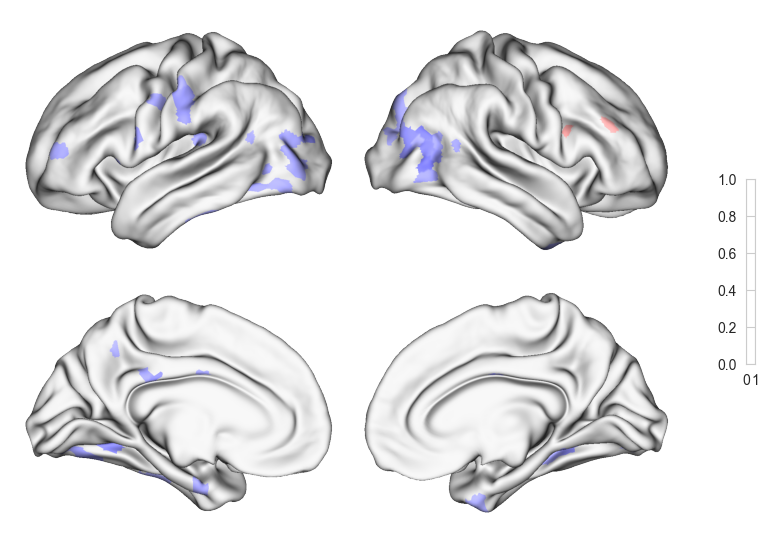

In [143]:
data = dfcr['early__RLScore']
data = data.apply(lambda row: row['r'] if row['p']<.05 else None, axis=1)
data = data.loc[region_names]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-1,1))
_ = p.build()

# permutation test

## on network level
levels 1 and 2

In [113]:
from pingouin import distance_corr

In [114]:
from tqdm import tqdm
tqdm.pandas()

In [115]:
def perm_test(df, feature, metric):  return distance_corr(df[feature], df[metric], seed=0, n_boot=500)[1] # pvalue

In [ ]:
# on 7 networks 'Cont' level 1
perm_test(df.xs('Cont', level=1, axis=0), feature='baseline', metric='tscore')

In [119]:
dfperm17 = []
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore']
for y in Y:
    for x in X:
        # level is 2 for 17 networks
        p = df.groupby(level=2).progress_apply(perm_test, feature=x, metric=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        dfperm17.append(pd.concat([p, pcorr], axis=1, keys=['p', 'pcor']))
dfperm17 = pd.concat(dfperm17, axis=1, keys=[x+'__'+y for x in X for y in Y])

100%|██████████| 19/19 [03:30<00:00, 11.08s/it]


In [142]:
# dfperm17.to_csv('data/permutation_17nets.csv')

<AxesSubplot:ylabel='17net'>

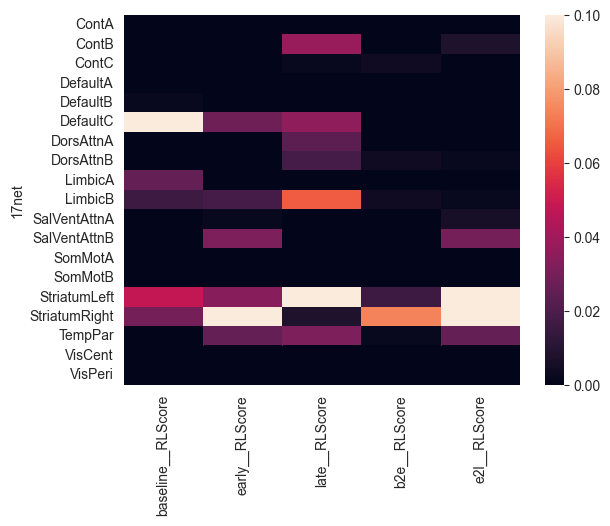

In [124]:
seaborn.heatmap(dfperm17.xs('p', axis=1, level=1), vmin=0, vmax=.1)

<AxesSubplot:ylabel='17net'>

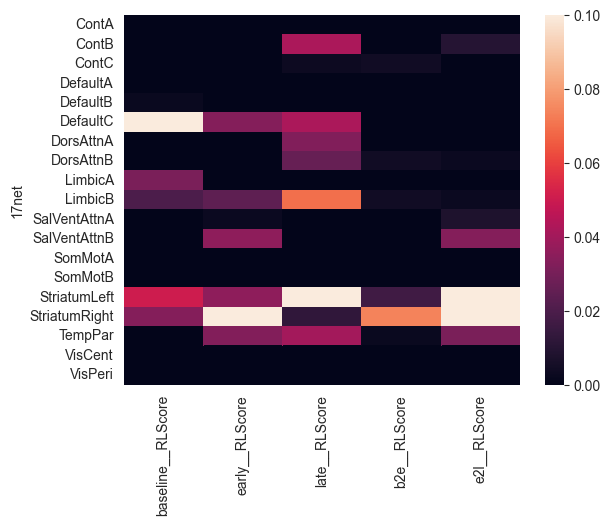

In [125]:
seaborn.heatmap(dfperm17.xs('pcor', axis=1, level=1), vmin=0, vmax=.1)

### on 7 networks

In [ ]:
dfperm7 = []
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore']
for y in Y:
    for x in X:
        # level is 1 for 7 networks
        p = df.groupby(level=1).progress_apply(perm_test, feature=x, metric=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        dfperm7.append(pd.concat([p, pcorr], axis=1, keys=['p', 'pcor']))
dfperm7 = pd.concat(dfperm7, axis=1, keys=[x+'__'+y for x in X for y in Y])

## regoins

In [61]:
df

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-7.195868,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-7.195868,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-7.195868,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-7.195868,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-7.195868,-1.179789
...,...,...,...,...,...,...,...,...,...,...,...
Right Caudate,Striatum,StriatumRight,46,ZN1,1.205411,1.602331,2.248230,0.396920,0.645899,-1.138829,-0.116459
Right Hippocampus,Striatum,StriatumRight,46,ZN1,2.247534,2.148846,2.141526,-0.098688,-0.007320,-1.138829,-0.116459
Right Pallidum,Striatum,StriatumRight,46,ZN1,1.111373,1.411745,1.556685,0.300372,0.144939,-1.138829,-0.116459


In [59]:
df.loc['7Networks_LH_Cont_Cing_1']

baseline     early      late       b2e  \
7net 17net        subject Subject                                           
Cont SalVentAttnB 1       AB1      1.579930  2.510811  3.351414  0.930881   
                  2       AG1      3.517658  3.823488  2.389208  0.305830   
                  3       AH1      2.335139  1.983248  1.571522 -0.351890   
                  4       AM1      1.927699  2.389032  2.718790  0.461333   
                  6       AP1      1.844896  2.818948  0.990385  0.974052   
                  7       AV1      3.536721  1.781280  1.582131 -1.755441   
                  8       BN1      1.685159  1.928411  2.518372  0.243252   
                  9       CD1      2.541401  1.605992  2.408289 -0.935409   
                  10      CG1      2.163047  2.149965  3.746296 -0.013082   
                  11      CH1      1.920260  2.552032  3.042574  0.631771   
                  12      CK1      1.660527  2.284115  4.494268  0.623588   
                  13      CM1      2.084163  1.595539  1.799677 -0.488624   
                  14      CM2      2.787100  2.914182  2.982514  0.127082   
                  15      CS1      2.535155  1.833316  3.181236 -0.701839   
                  16      EH1      1.813324  4.646819  2.806612  2.833496   
                  17      EK1      2.345408  2.941076  3.190370  0.595667   
                  18      HK1      2.660456  2.234464  3.030312 -0.425993   
                  19      HS1      2.316271  2.818323  2.346968  0.502053   
                  20      JC1      2.287415  1.833660  3.830116 -0.453756   
                  21      JH1      2.379764  3.137212  3.495661  0.757448   
                  23      JM1      2.969953  1.433003  1.684791 -1.536950   
                  24      JR1      2.556985  2.086329  1.500293 -0.470656   
                  26      KK1      2.248285  3.395986  0.675521  1.147700   
                  28      KP1      1.181847  3.983517  2.878301  2.801671   
                  29      KR1      2.927040  2.623971  2.806905 -0.303068   
                  30      LB1      2.764953  2.052787  3.031407 -0.712166   
                  31      MB1      0.910315  4.251804  2.656542  3.341489   
                  32      MG1      1.903308  2.077636  2.300513  0.174329   
                  33      MP1      2.257331  1.197777  3.522655 -1.059554   
                  35      NW1      2.042179  1.965599  1.478230 -0.076581   
                  38      SK1      2.589592  1.151595  3.515735 -1.437997   
                  40      SM2      2.036498  3.180592  0.716461  1.144094   
                  41      SR1      3.260708  1.704357  2.868869 -1.556351   
                  44      UP1      3.093398  2.032582  1.658464 -1.060816   
                  45      WK1      4.005707  3.082868  2.473592 -0.922838   
                  46      ZN1      2.303472  2.509474  3.201352  0.206002   

                                        e2l     tscore   RLScore  
7net 17net        subject Subject                                 
Cont SalVentAttnB 1       AB1      0.840603  -7.195868 -1.179789  
                  2       AG1     -1.434280  -5.822339  1.104018  
                  3       AH1     -0.411727  -2.248812 -0.302101  
                  4       AM1      0.329758  -6.593196 -1.400917  
                  6       AP1     -1.828563 -15.539946  0.868475  
                  7       AV1     -0.199149  -4.009663  0.859943  
                  8       BN1      0.589961  -6.426085  1.433999  
                  9       CD1      0.802297 -11.893333 -0.661215  
                  10      CG1      1.596331  -3.318209 -0.337563  
                  11      CH1      0.490543  -3.573430 -0.088406  
                  12      CK1      2.210153 -18.086867 -0.719677  
                  13      CM1      0.204138  -7.138170  0.220940  
                  14      CM2      0.068332  -4.033090  1.491491  
                  15      CS1      1.347920 -29.750010 -1.698549  
                  16      EH1     -1

In [ ]:
def perm_test(df, feature, metric):  return distance_corr(df[feature], df[metric], seed=0)[1] # pvalue

In [71]:
df.groupby(level=0).progress_apply(perm_test, feature='baseline', metric='tscore')

100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


In [ ]:
dfperm = []
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore']
for y in Y:
    for x in X:
        p = df.groupby(level=0).progress_apply(perm_test, feature=x, metric=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        dfperm.append(pd.concat([p, pcorr], axis=1, keys=['p', 'pcor']))

In [94]:
dfperm = pd.concat(dfperm, axis=1, keys=[x+'__'+y for x in X for y in Y])

In [111]:
# dfperm.to_csv('data/permutation_regions.csv')

In [134]:
(dfperm.xs('p', level=1, axis=1) < .05).sum()

baseline__RLScore    35
early__RLScore       61
late__RLScore        35
b2e__RLScore         51
e2l__RLScore         55
dtype: int64

TypeError: __init__() got an unexpected keyword argument 'location'

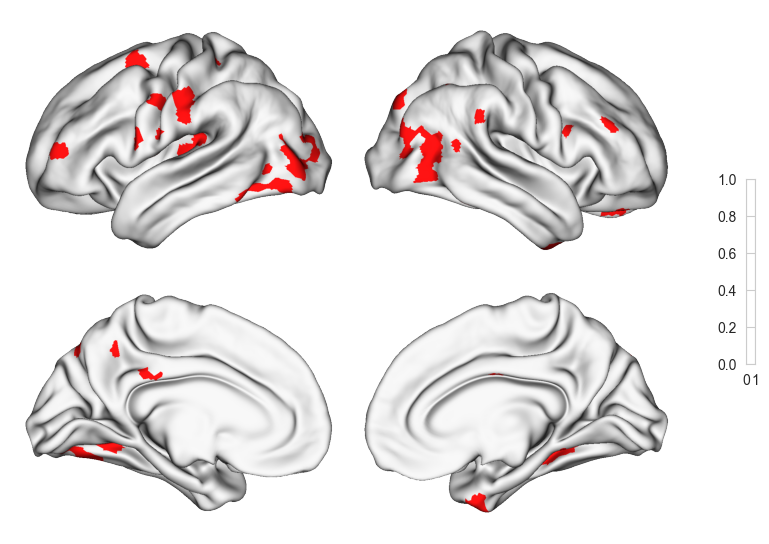

In [141]:
data = dfperm['early__RLScore']
data = data.loc[region_names]
data = data['p'] < .05
data = data.loc[region_names]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-1,1))
_ = p.build()